In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
import math
import unicodedata
import re
import gc
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import CustomBert
from CustomBert import CustomBertForMaskedLM
from CustomBert import CustomBertConfig
from WordPieceTokenizer import WordPieceTokenizer as Tokenizer
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from PretrainDataset import TokenizedDataset
from PretrainDataset import CustomDataCollatorForMLM

In [2]:
def group_texts(examples, tokenizer, MAX_SEQUENCE_LENGTH):
    import torch
    concatenated_text = " ".join(examples["text"])

    encoded_output = tokenizer.encode(
        concatenated_text,
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding=True,
        add_special_tokens=True
    )
    
    return {
        "input_ids": [torch.tensor(encoded_output['input_ids'], dtype=torch.long)],
        "attention_mask": [torch.tensor(encoded_output['attention_mask'], dtype=torch.long)],
        "token_type_ids": [torch.tensor(encoded_output['token_type_ids'], dtype=torch.long)],
    }

In [3]:
tokenizer = Tokenizer(vocab_file_path="saves/vocab.txt",do_lower_case=False,strip_accents=False,clean_text=True)
VOCAB_SIZE = tokenizer.get_vocab_size()
MAX_SEQUENCE_LENGTH = 64
BATCH_SIZE = 80

num_cpu_cores = os.cpu_count()
num_processes_to_use = num_cpu_cores if num_cpu_cores is not None else 1

datasetsPath = 'datasets/'
TRAIN_TEXT_DIR = f'{datasetsPath}train'
VAL_TEXT_DIR = f'{datasetsPath}validation'

train_text_files = [os.path.join(TRAIN_TEXT_DIR, f) for f in os.listdir(TRAIN_TEXT_DIR) if f.endswith('.txt')]
val_text_files = [os.path.join(VAL_TEXT_DIR, f) for f in os.listdir(VAL_TEXT_DIR) if f.endswith('.txt')]

if not train_text_files or not val_text_files:
    exit()
print(f'총 {len(train_text_files)}개의 학습 텍스트 파일 로드 시작...')
train_raw_dataset = load_dataset("text", data_files={"train": train_text_files}, split="train")
print(f"원시 데이터셋 로드 완료. 총 {len(train_raw_dataset)}개의 샘플.")

print(f'총 {len(val_text_files)}개의 검증 텍스트 파일 로드 시작...')
val_raw_dataset = load_dataset("text", data_files={"validation": val_text_files}, split="validation")
print(f"원시 데이터셋 로드 완료. 총 {len(val_raw_dataset)}개의 샘플.")
    
print('학습 데이터셋 토큰화 및 청킹 시작...')
train_tokenized_dataset = train_raw_dataset.map(
    group_texts,
    batched=True,
    num_proc=num_processes_to_use,
    remove_columns=["text"],
    fn_kwargs={"tokenizer":tokenizer,"MAX_SEQUENCE_LENGTH":MAX_SEQUENCE_LENGTH},
    desc=f"맵핑 학습 데이터셋 (토큰화 및 청킹, 최대 길이 {MAX_SEQUENCE_LENGTH})"
)
print(len(train_tokenized_dataset))

print('검증 데이터셋 토큰화 및 청킹 시작...')
val_tokenized_dataset = val_raw_dataset.map(
    group_texts,
    batched=True,
    num_proc=num_processes_to_use,
    remove_columns=["text"],
    fn_kwargs={"tokenizer":tokenizer,"MAX_SEQUENCE_LENGTH":MAX_SEQUENCE_LENGTH},
    desc=f"맵핑 검증 데이터셋 (토큰화 및 청킹, 최대 길이 {MAX_SEQUENCE_LENGTH})"
)
print(len(val_tokenized_dataset))


총 4개의 학습 텍스트 파일 로드 시작...
원시 데이터셋 로드 완료. 총 29091153개의 샘플.
총 4개의 검증 텍스트 파일 로드 시작...
원시 데이터셋 로드 완료. 총 3554992개의 샘플.
학습 데이터셋 토큰화 및 청킹 시작...
29100
검증 데이터셋 토큰화 및 청킹 시작...
3564


In [4]:
print("토큰화된 학습 데이터셋 저장 중...")
tokenized_dataset_path = "datasets/tokenized_dataset/train"
train_tokenized_dataset.save_to_disk(tokenized_dataset_path)
print(f"토큰화된 데이터셋이 '{tokenized_dataset_path}'에 저장되었습니다.")

print("토큰화된 검증 데이터셋 저장 중...")
tokenized_dataset_path = "datasets/tokenized_dataset/validation"
val_tokenized_dataset.save_to_disk(tokenized_dataset_path)
print(f"토큰화된 데이터셋이 '{tokenized_dataset_path}'에 저장되었습니다.")

토큰화된 학습 데이터셋 저장 중...


Saving the dataset (0/1 shards):   0%|          | 0/29100 [00:00<?, ? examples/s]

토큰화된 데이터셋이 'datasets/tokenized_dataset/train'에 저장되었습니다.
토큰화된 검증 데이터셋 저장 중...


Saving the dataset (0/1 shards):   0%|          | 0/3564 [00:00<?, ? examples/s]

토큰화된 데이터셋이 'datasets/tokenized_dataset/validation'에 저장되었습니다.


In [5]:
train_dataset = TokenizedDataset(train_tokenized_dataset)
val_dataset = TokenizedDataset(val_tokenized_dataset)

data_collator = CustomDataCollatorForMLM(tokenizer=tokenizer, mlm_probability=0.15)

cpu_cnt = os.cpu_count()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=cpu_cnt,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=cpu_cnt,
    pin_memory=True
)

print(f"PyTorch DataLoader 생성 완료. 배치 크기: {BATCH_SIZE}")
print(f"총 훈련 배치 수: {len(train_dataloader)}")
print(f"총 검증 배치 수: {len(val_dataloader)}")

PyTorch DataLoader 생성 완료. 배치 크기: 80
총 훈련 배치 수: 364
총 검증 배치 수: 45


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_SAVE_PATH = "saves/Pretrain.pt"

HIDDEN_SIZE = 768
NUM_HIDDEN_LAYERS = 12
NUM_ATTENTION_HEADS = 12
INTERMEDIATE_SIZE = 3072
TYPE_VOCAB_SIZE = 2
DROPOUT_PROB = 0.1

config = CustomBertConfig(
    VOCAB_SIZE=VOCAB_SIZE,
    HIDDEN_SIZE=HIDDEN_SIZE,
    NUM_HIDDEN_LAYERS=NUM_HIDDEN_LAYERS,
    NUM_ATTENTION_HEADS=NUM_ATTENTION_HEADS,
    INTERMEDIATE_SIZE=INTERMEDIATE_SIZE,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH,
    TYPE_VOCAB_SIZE=TYPE_VOCAB_SIZE,
    DROPOUT_PROB=DROPOUT_PROB
)

model = CustomBertForMaskedLM(config)

if os.path.exists(MODEL_SAVE_PATH):
    print("모델 가중치 로드 중...")
    # 먼저 CPU에 로드한 후 모델에 로드합니다.
    loaded_state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu')
    model.load_state_dict(loaded_state_dict)
    print("모델 가중치 로드 완료.")
else:
    print("새로운 모델 초기화 완료. 저장된 가중치를 찾을 수 없습니다.")

model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Custom Bert 모델 초기화 완료. 총 학습 가능 파라미터 수 : {num_params}')
print(f'모델이 담긴 장치 : {device}')

모델 가중치 로드 중...
모델 가중치 로드 완료.
Custom Bert 모델 초기화 완료. 총 학습 가능 파라미터 수 : 111051208
모델이 담긴 장치 : cuda


In [7]:
EPOCHS = 10
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 0.001
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_dataloader) * EPOCHS
WARMUP_STEPS = int(total_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,num_training_steps=total_steps)
print(f"총 학습 스텝 수: {total_steps}")
print(f"워밍업 스텝 수: {WARMUP_STEPS}")

총 학습 스텝 수: 3640
워밍업 스텝 수: 364


In [8]:
LOSS_PATH = f"saves/Pretrain_loss.txt"
BEST_ACCURACY_PATH = f"saves/Pretrain_best_accuracy.txt"
best_val_accuracy = 0.0
if os.path.exists(BEST_ACCURACY_PATH):
    with open(BEST_ACCURACY_PATH, 'r') as f:
        content = f.read()
        if content.strip():
            best_val_accuracy = float(content.strip())
            print(f"이전 최고 검증 정확도: {best_val_accuracy:.4f} 불러옴.")

if os.path.exists(LOSS_PATH):
    with open(LOSS_PATH,'r') as f:
        content = f.read()
        if content.strip():
            prev_loss = float(content.strip())
else:
    prev_loss = 100

train_losses = []
train_accuarcy = []
scaler = torch.amp.GradScaler()

print(f"\n<--- 학습 시작 ---> ({EPOCHS} 에폭)")

for e in range(EPOCHS):
    model.train()
    loss_sum = 0
    progress_bar = tqdm(train_dataloader, desc=f"Pre-train Epoch {e+1}")

    for step, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
                labels=batch["labels"]
            )
            loss = outputs["loss"]

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        loss_sum += loss.item()
        progress_bar.set_postfix({'train_loss': f"{(loss_sum/(step+1)):.4f}"})

        del outputs, loss
        if 'cuda' in str(device):
            torch.cuda.empty_cache()
        gc.collect()

    avg_train_loss = loss_sum / len(train_dataloader)
    train_losses.append(avg_train_loss)

    print(f"Pre-train Epoch {e+1} 완료. 평균 학습 손실: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    val_progressbar = tqdm(val_dataloader, desc=f"Pre-train Epoch {e+1} Valid")
    
    with torch.no_grad():
        for step, batch in enumerate(val_progressbar):        
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    token_type_ids=batch["token_type_ids"],
                    labels=batch["labels"]
                )
                loss = outputs["loss"]
                logits = outputs["logits"]
                
            total_val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)

            active_labels = batch["labels"].view(-1)
            active_predictions = predictions.view(-1)

            mask = (active_labels != -100)

            correct_predictions += (active_predictions[mask] == active_labels[mask]).sum().item()
            total_predictions += mask.sum().item()

            val_progressbar.set_postfix({'val_loss': f"{(total_val_loss/(step+1)):.4f}"})

            del outputs, loss, logits, predictions, active_labels, active_predictions, mask # 메모리 해제
            if 'cuda' in str(device):
                torch.cuda.empty_cache()
            gc.collect()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

        train_accuarcy.append(val_accuracy)
        print(f"Pre-train Epoch {e+1} 완료. 평균 검증 손실: {avg_val_loss:.4f}, 검증 정확도: {(val_accuracy*100):.2f}%")

        if val_accuracy > best_val_accuracy:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            best_val_accuracy = val_accuracy
            print(f"새로운 최고 검증 정확도 {(best_val_accuracy*100):.2f}% 달성! 모델 가중치 '{MODEL_SAVE_PATH}' 저장 완료.")
            
            with open(BEST_ACCURACY_PATH, 'w') as f:
                f.write(str(best_val_accuracy))
            print(f"최고 검증 정확도 '{BEST_ACCURACY_PATH}' 저장 완료.")
        else:
            print(f"현재 검증 정확도 ({(val_accuracy*100):.2f}%)는 최고 정확도 ({(best_val_accuracy*100):.2f}%)보다 낮습니다. 모델을 저장하지 않습니다.")

print("\n<--- 학습 완료 --->")

이전 최고 검증 정확도: 0.0710 불러옴.

<--- 학습 시작 ---> (10 에폭)


Pre-train Epoch 1:   0%|          | 0/364 [00:26<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_5320\530920594.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Pre-train Epoch 1 완료. 평균 학습 손실: 7.5585


Pre-train Epoch 1 Valid:   0%|          | 0/45 [00:24<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_5320\530920594.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Pre-train Epoch 1 완료. 평균 검증 손실: 7.5123, 검증 정확도: 6.91%
현재 검증 정확도 (6.91%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 2:   0%|          | 0/364 [00:26<?, ?it/s]

Pre-train Epoch 2 완료. 평균 학습 손실: 7.5475


Pre-train Epoch 2 Valid:   0%|          | 0/45 [00:24<?, ?it/s]

Pre-train Epoch 2 완료. 평균 검증 손실: 7.5153, 검증 정확도: 6.84%
현재 검증 정확도 (6.84%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 3:   0%|          | 0/364 [00:26<?, ?it/s]

Pre-train Epoch 3 완료. 평균 학습 손실: 7.5442


Pre-train Epoch 3 Valid:   0%|          | 0/45 [00:25<?, ?it/s]

Pre-train Epoch 3 완료. 평균 검증 손실: 7.5022, 검증 정확도: 7.06%
현재 검증 정확도 (7.06%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 4:   0%|          | 0/364 [00:27<?, ?it/s]

Pre-train Epoch 4 완료. 평균 학습 손실: 7.5372


Pre-train Epoch 4 Valid:   0%|          | 0/45 [00:24<?, ?it/s]

Pre-train Epoch 4 완료. 평균 검증 손실: 7.5223, 검증 정확도: 6.98%
현재 검증 정확도 (6.98%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 5:   0%|          | 0/364 [00:26<?, ?it/s]

Pre-train Epoch 5 완료. 평균 학습 손실: 7.5378


Pre-train Epoch 5 Valid:   0%|          | 0/45 [00:24<?, ?it/s]

Pre-train Epoch 5 완료. 평균 검증 손실: 7.4944, 검증 정확도: 7.09%
현재 검증 정확도 (7.09%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 6:   0%|          | 0/364 [00:26<?, ?it/s]

Pre-train Epoch 6 완료. 평균 학습 손실: 7.5277


Pre-train Epoch 6 Valid:   0%|          | 0/45 [00:25<?, ?it/s]

Pre-train Epoch 6 완료. 평균 검증 손실: 7.5165, 검증 정확도: 6.73%
현재 검증 정확도 (6.73%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 7:   0%|          | 0/364 [00:30<?, ?it/s]

Pre-train Epoch 7 완료. 평균 학습 손실: 7.5329


Pre-train Epoch 7 Valid:   0%|          | 0/45 [00:25<?, ?it/s]

Pre-train Epoch 7 완료. 평균 검증 손실: 7.5120, 검증 정확도: 7.06%
현재 검증 정확도 (7.06%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 8:   0%|          | 0/364 [00:29<?, ?it/s]

Pre-train Epoch 8 완료. 평균 학습 손실: 7.5294


Pre-train Epoch 8 Valid:   0%|          | 0/45 [00:26<?, ?it/s]

Pre-train Epoch 8 완료. 평균 검증 손실: 7.5049, 검증 정확도: 7.05%
현재 검증 정확도 (7.05%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 9:   0%|          | 0/364 [00:29<?, ?it/s]

Pre-train Epoch 9 완료. 평균 학습 손실: 7.5299


Pre-train Epoch 9 Valid:   0%|          | 0/45 [00:25<?, ?it/s]

Pre-train Epoch 9 완료. 평균 검증 손실: 7.5065, 검증 정확도: 6.83%
현재 검증 정확도 (6.83%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.


Pre-train Epoch 10:   0%|          | 0/364 [00:27<?, ?it/s]

Pre-train Epoch 10 완료. 평균 학습 손실: 7.5246


Pre-train Epoch 10 Valid:   0%|          | 0/45 [00:25<?, ?it/s]

Pre-train Epoch 10 완료. 평균 검증 손실: 7.5059, 검증 정확도: 6.91%
현재 검증 정확도 (6.91%)는 최고 정확도 (7.10%)보다 낮습니다. 모델을 저장하지 않습니다.

<--- 학습 완료 --->


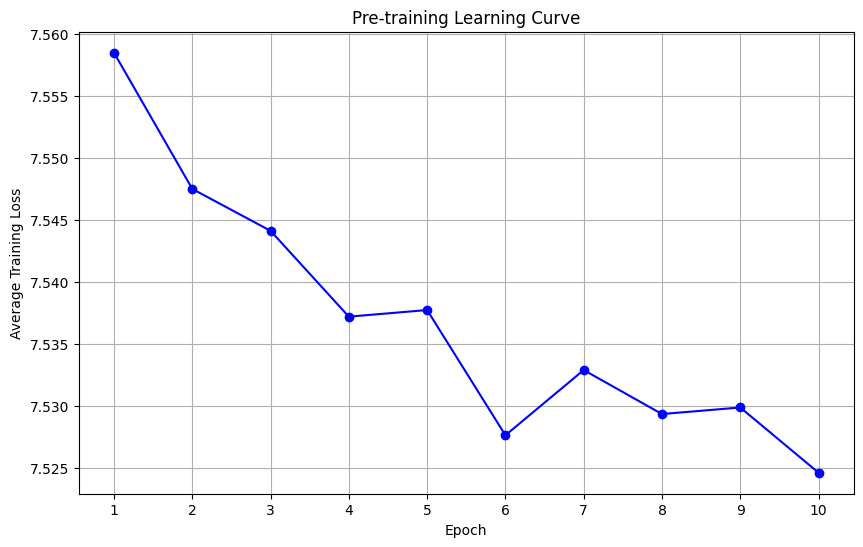

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Pre-training Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.show()

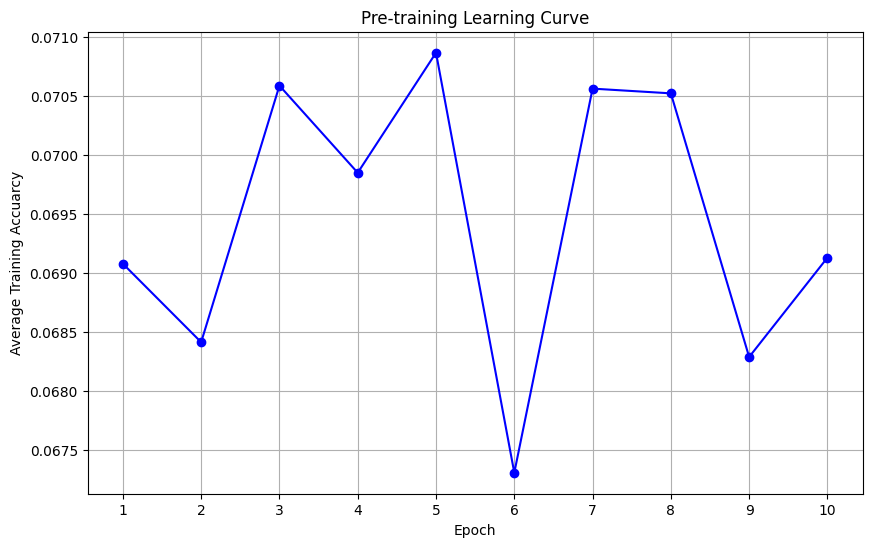

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_accuarcy, marker='o', linestyle='-', color='b')
plt.title('Pre-training Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Training Accuarcy')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.show()

In [11]:
print(train_losses)

[7.55851982321058, 7.547531754105956, 7.544151843249143, 7.53723005934076, 7.537764372406425, 7.527661753224803, 7.532924923267993, 7.529376159657489, 7.529903947652041, 7.524642094151004]


In [12]:
print(train_accuarcy)

[0.06907841421115757, 0.06841292315613336, 0.07058861536473476, 0.06984986146014563, 0.07086765601461585, 0.06730614478385424, 0.07056321690939554, 0.07052308086305141, 0.06828745084018592, 0.069129763130793]


In [13]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)